In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
df = pd.read_csv('../data/train.csv')

In [114]:
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [115]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

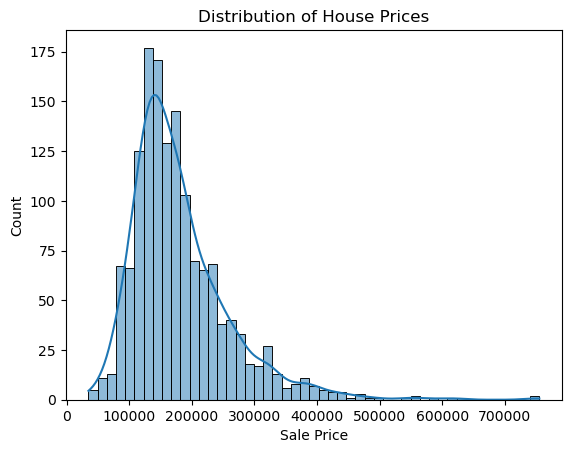

In [116]:
# Visualize target variable distribution
import os
os.makedirs('notebooks', exist_ok=True)
sns.histplot(df['SalePrice'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.savefig('notebooks/type_distribution.png', dpi=300, bbox_inches='tight')


plt.show()

In [117]:
# Correlation matrix with SalePrice
corr = df.corr(numeric_only=True)
top_corr = corr['SalePrice'].sort_values(ascending=False).head(10)

print(top_corr)


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


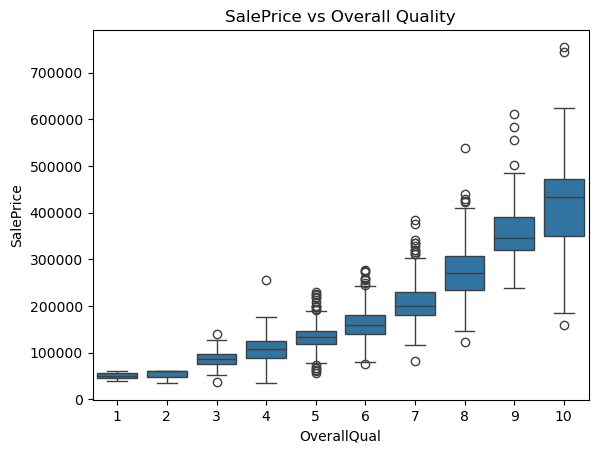

In [118]:
# Example: OverallQual vs SalePrice
sns.boxplot(x='OverallQual', y='SalePrice', data=df)
plt.title('SalePrice vs Overall Quality')
plt.show()


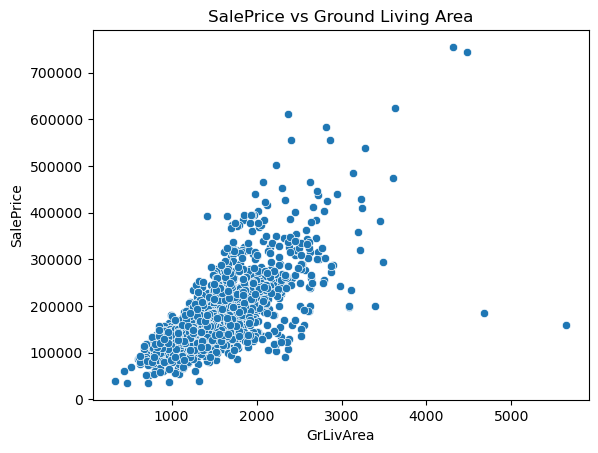

In [119]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.title('SalePrice vs Ground Living Area')
plt.show()

In [120]:
# Find features with missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [121]:
# Fill NA for numerical columns with median
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

if 'GarageType' in df.columns:
    df['GarageType'] = df['GarageType'].fillna('None')

In [122]:
# Combine related features
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# Log-transform the target to reduce skew
import numpy as np
df['SalePrice'] = np.log1p(df['SalePrice'])

In [123]:
df = pd.get_dummies(df)

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [125]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
missing = X.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

GarageYrBlt    81
MasVnrArea      8
dtype: int64

In [128]:
# For numerical columns
X = X.fillna(X.median(numeric_only=True))

# For categorical columns
X = X.fillna("None")

In [129]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Define categorical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit on training data categorical columns
X_train_encoded = encoder.fit_transform(X_train[cat_cols])
X_test_encoded = encoder.transform(X_test[cat_cols])

# Convert encoded arrays to DataFrames with proper column names
encoded_train_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(cat_cols))
encoded_test_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(cat_cols))

# Align index to original data
encoded_train_df.index = X_train.index
encoded_test_df.index = X_test.index

# Drop original categorical columns and concatenate the new one-hot encoded columns
X_train = pd.concat([X_train.drop(columns=cat_cols), encoded_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=cat_cols), encoded_test_df], axis=1)



In [130]:
from sklearn.impute import SimpleImputer

# Auto-detect categorical columns if not already defined
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Check that categorical columns are present in X_train
valid_cat_cols = [col for col in cat_cols if col in X_train.columns]

if valid_cat_cols:
    # Impute categorical columns with a constant value "Missing"
    cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
    
    # Fit and transform on train data
    X_train[valid_cat_cols] = cat_imputer.fit_transform(X_train[valid_cat_cols])
    
    # Only transform on test data
    X_test[valid_cat_cols] = cat_imputer.transform(X_test[valid_cat_cols])
else:
    print("⚠️ No valid categorical columns found for imputation.")



⚠️ No valid categorical columns found for imputation.


In [131]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import joblib
import pandas as pd
import json

# Assuming X_train and y_train are already loaded as DataFrames/Series

# 1. Fill missing values in X_train and convert bools to ints (if needed)
X_train = X_train.fillna(0)
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)

# 2. Detect numeric and categorical columns automatically
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# 3. Define preprocessing transformers
numeric_transformer = SimpleImputer(strategy='constant', fill_value=0)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Create the full pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# 5. Fit the pipeline
pipeline.fit(X_train, y_train)

# 6. Save the full pipeline
joblib.dump(pipeline, '../model_pipeline.pkl')

# 7. Save expected feature names for later input construction
expected_features = numeric_features + categorical_features
with open('../expected_features.json', 'w') as f:
    json.dump(expected_features, f)

# 8. Save dtypes of training features for consistent input casting later
dtypes_dict = X_train.dtypes.apply(lambda x: x.name).to_dict()
with open('../feature_dtypes.json', 'w') as f:
    json.dump(dtypes_dict, f)


In [132]:
# Fill NaNs in X_test with zeros or other strategy
X_test = X_test.fillna(0)

# Also convert booleans to integers (to match training data type)
X_test = X_test.astype({col: int for col in X_test.select_dtypes(bool).columns})

# Now predict
y_pred = model.predict(X_test)


In [133]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.13275599576442212


In [134]:
# Calculate R² score
from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

R² Score: 0.9055567169722437


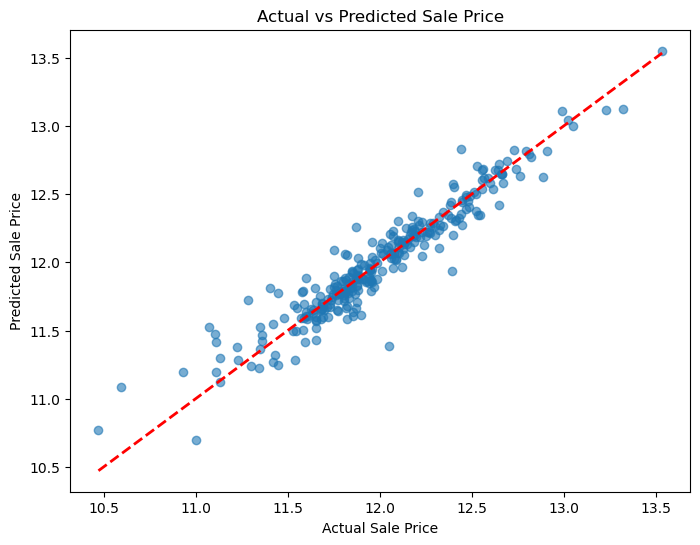

In [135]:
# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price')

# Save figure
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')

plt.show()